In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pickle

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from statistics import mean
from sklearn.metrics import accuracy_score

from shared_interest.shared_interest import shared_interest
from shared_interest.util import flatten, binarize_std, normalize_0to1
from interpretability_methods.vanilla_gradients import VanillaGradients

In [3]:
class ColoredMNIST(torchvision.datasets.MNIST):
    """Extends ImageFolder dataset to include ground truth annotations."""

    def __init__(self, root, train = True, download = True, transform=None, correlation = False, digit_as_ground_truth = True):
        super().__init__(root, train, transform, None, download)
        self.digit_as_ground_truth = digit_as_ground_truth
        self.correlation = correlation
        self.colors = ['(230,25,75)', '(245,130,48)', '(255,225,25)', '(210, 245,60)', '(60,180,75)', '(70,240,240)', '(0,130,200)', '(145,30,180)', '(240,50,230)', '(0,0,128)']
        if (not self.correlation) and (not self.train):
            random.shuffle(self.colors)
        
    def __getitem__(self, index):
        """Returns the image, ground_truth mask, and label of the image."""
        image, label = super().__getitem__(index)
        
        # inverting black to white , white to black
        image = torchvision.transforms.functional.invert(image).numpy()
        ground_truth = self._create_ground_truth(image, self.digit_as_ground_truth)
        
        # adding color
        color_idx = label
        if (not self.correlation) and self.train:
            color_idx = random.randint(0,9)
        color = self.colors[color_idx].split(",")
        for c in range(3):
            c_color = color[c].replace('(','').replace(')','')
            for i in range(5):
                for j in range(5):
                    image[c][i][j] = bytes(c_color, 'utf-8')
        image = torch.from_numpy(image)
        normalize = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(),
                                                    torchvision.transforms.ToTensor()])
        
        img_nr = normalize(image).float()
        ground_truth_nr = torch.squeeze(normalize(ground_truth), 0)
        return img_nr, ground_truth_nr, label
    
    def _create_ground_truth(self, image, digit_as_ground_truth):
        """Creates a binary groudn truth mask based on the ImageNet annotations."""
        ground_truth = torch.zeros((28, 28))
        if digit_as_ground_truth:
            non_black_pixels = np.where(
                (image[0, :, :] < 255) & 
                (image[1, :, :] < 255) & 
                (image[2, :, :] < 255)
            )
            ground_truth[non_black_pixels] = 1
        else:
            # ground truth as color block 
            for i in range(5):
                for j in range(5):
                    ground_truth[i][j] = 1
        return ground_truth

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # First 2D convolutional layer, taking in 1 input channel (image),
        # outputting 32 convolutional features, with a square kernel size of 3
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        # Second 2D convolutional layer, taking in the 32 input layers,
        # outputting 64 convolutional features, with a square kernel size of 3
        self.conv2 = nn.Conv2d(32, 64, 3, 1)

        # Designed to ensure that adjacent pixels are either all 0s or all active
        # with an input probability
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

        # First fully connected layer
        self.fc1 = nn.Linear(9216, 128)
        # Second fully connected layer that outputs our 10 labels
        self.fc2 = nn.Linear(128, 10)
        # fully connected layer, output 10 classes
        
    def forward(self, x):
        # Pass data through conv1
        x = self.conv1(x)
        # Use the rectified-linear activation function over x
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        # Run max pooling over x
        x = F.max_pool2d(x, 2)
        # Pass data through dropout1
        x = self.dropout1(x)
        # Flatten x with start_dim=1
        x = torch.flatten(x, 1)
        # Pass data through ``fc1``
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        # Apply softmax to x
        output = F.log_softmax(x, dim=1)
        return output

In [5]:
def ax_off(ax):
    ax.tick_params(
        which='both',
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labeltop=False,
        labelleft=False,
        labelright=False,
    )

In [6]:
normal_train_data = ColoredMNIST('data', train = True, download = True, 
                          transform= torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=3),
                                                                     torchvision.transforms.PILToTensor()]),
                         correlation = False)
corr_train_data = ColoredMNIST('data', train = True, download = True, 
                          transform= torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=3),
                                                                     torchvision.transforms.PILToTensor()]),
                         correlation = True)
normal_test_data = ColoredMNIST('data', train = False, download = True, 
                          transform= torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=3),
                                                                     torchvision.transforms.PILToTensor()]),
                         correlation = False)
corr_test_data = ColoredMNIST('data', train = False, download = True, 
                          transform= torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=3),
                                                                     torchvision.transforms.PILToTensor()]),
                         correlation = True)

In [7]:
normal_train_loader = torch.utils.data.DataLoader(normal_train_data, batch_size=64, shuffle=True)
corr_train_loader = torch.utils.data.DataLoader(corr_train_data, batch_size=64, shuffle=True)


normal_test_loader = torch.utils.data.DataLoader(normal_test_data, batch_size=64, shuffle=False)
corr_test_loader = torch.utils.data.DataLoader(corr_test_data, batch_size=64, shuffle=False)

In [8]:
color_anno_normal = ColoredMNIST('data', train = False, download = True, 
                          transform= torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=3),
                                                                     torchvision.transforms.PILToTensor()]),
                         correlation = False, digit_as_ground_truth = False)
color_anno_corr = ColoredMNIST('data', train = False, download = True, 
                          transform= torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=3),
                                                                     torchvision.transforms.PILToTensor()]),
                         correlation = True, digit_as_ground_truth = False)

In [9]:
color_anno_normal_loader = torch.utils.data.DataLoader(color_anno_normal, batch_size=64, shuffle=False)
color_anno_corr_loader = torch.utils.data.DataLoader(color_anno_corr, batch_size=64, shuffle=False)

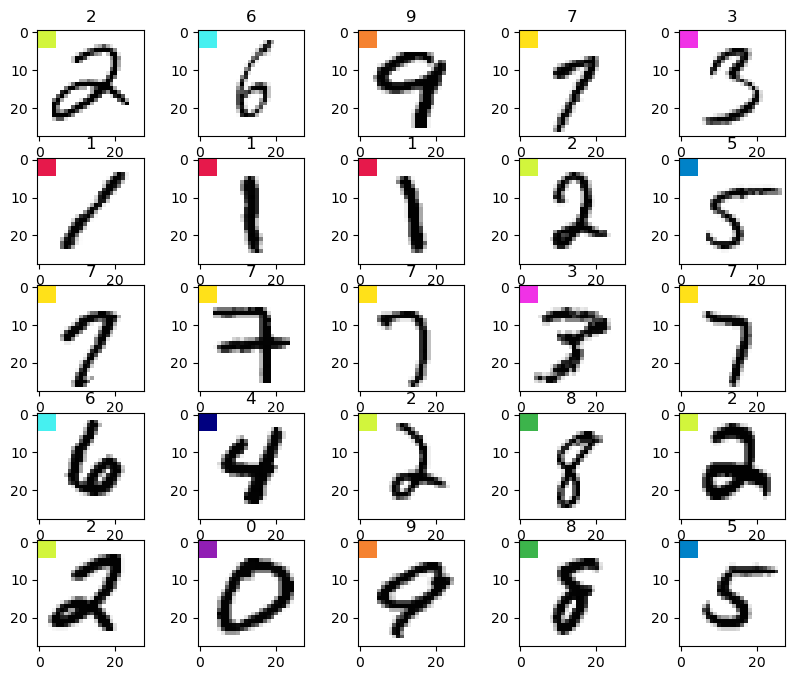

In [10]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(normal_test_data), size=(1,)).item()
    img, ground_truth, label = normal_test_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.imshow(img.permute(1,2,0))
plt.show()

In [11]:
def binarize_threshold(batch, threshold):
    batch_normalized = normalize_0to1(batch)
    binary_mask = (batch_normalized >= threshold).astype('uint8')
    return binary_mask

In [12]:
def train(epoch, device, model, optimizer, train_loader):
    model.train()
    for batch_idx, (data, ground_truth, target) in enumerate(tqdm(train_loader)):
        data, target = (data).to(device), target.to(device)
        ground_truth = ground_truth.numpy()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
    print('Train Epoch: {} [({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, 100. * batch_idx / len(train_loader), loss.item()))

In [13]:
def test(model, device, test_loader):
    model.eval()
    saliency_method = VanillaGradients(model)
    
    salient_pixel_count = 0
    accuracy = 0
    total_shared_interest_scores = {'iou_coverage': np.array([]),
                                    'ground_truth_coverage': np.array([]),
                                    'saliency_coverage': np.array([]),}
    total_saliency_masks = np.array([[[]]])
    total_predictions = np.array([])

    for i, (images, ground_truth, labels) in enumerate(tqdm(test_loader)):
        with torch.no_grad():
            images = images.to(device)
            ground_truth = ground_truth.numpy()
            labels = labels.numpy()
            
            output = model(images)
            # pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            # correct += pred.eq(target.view_as(pred)).sum().item()
            
            predictions = torch.argmax(output, dim=1).detach().cpu().numpy()
            total_predictions = np.concatenate((total_predictions, predictions))

        # Update metrics
        accuracy += accuracy_score(labels, predictions)
            
        saliency = flatten(saliency_method.get_saliency(images))
        saliency_masks = binarize_std(saliency)

        if i == 0: 
            total_saliency_masks = saliency_masks
        else:
            total_saliency_masks = np.concatenate((total_saliency_masks, saliency_masks))

        # Compute Shared Interest scores
        for score in total_shared_interest_scores:
            shared_interest_scores = shared_interest(ground_truth, saliency_masks, score=score)
            total_shared_interest_scores[score] = np.concatenate((total_shared_interest_scores[score], shared_interest_scores))

        # Compute Pointing Game
        for j in range(saliency.shape[0]):
            saliency_batch = saliency[j]
            ground_truth_batch = ground_truth[j]
            pixel = np.unravel_index(saliency_batch.argmax(), saliency_batch.shape)
            point = ground_truth_batch[pixel[0], pixel[1]]

            # check if most salient feature is in ground truth 
            if point > 0:
                salient_pixel_count += 1
    
    pointing_game = salient_pixel_count / len(test_loader.dataset)
    accuracy /= i + 1
    print('Accuracy: %.2f' %accuracy)
    print('IoU coverage: ' + str(mean(total_shared_interest_scores['iou_coverage'])))
    print('Pointing Game: ' + str(pointing_game))

    return accuracy, pointing_game, total_saliency_masks, total_shared_interest_scores, total_predictions

In [16]:
data_dir = ""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
original_model = Net().to(device)
optimizer = optim.SGD(original_model.parameters(), lr=0.01,
                      momentum=0.5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

n_epochs = 4
for epoch in range(1, n_epochs + 1):
    train(epoch, device, original_model, optimizer, normal_train_loader)
    scheduler.step()

torch.save(original_model.state_dict(), data_dir + 'original_model.pt')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [01:43<00:00,  9.08it/s]


Train Epoch: 1 [(100%)]	Loss: 0.393035


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [01:40<00:00,  9.34it/s]


Train Epoch: 2 [(100%)]	Loss: 0.165963


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [01:40<00:00,  9.31it/s]


Train Epoch: 3 [(100%)]	Loss: 0.048992


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [01:40<00:00,  9.32it/s]


Train Epoch: 4 [(100%)]	Loss: 0.082382


In [17]:
data_dir = ""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
spurious_model = Net().to(device)
optimizer = optim.SGD(spurious_model.parameters(), lr=0.01,
                      momentum=0.5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

n_epochs = 4
for epoch in range(1, n_epochs + 1):
    train(epoch, device, spurious_model, optimizer, corr_train_loader)
    scheduler.step()

torch.save(spurious_model.state_dict(), data_dir + 'spurious_model.pt')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [01:40<00:00,  9.37it/s]


Train Epoch: 1 [(100%)]	Loss: 0.112442


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [01:40<00:00,  9.37it/s]


Train Epoch: 2 [(100%)]	Loss: 0.013002


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [01:40<00:00,  9.33it/s]


Train Epoch: 3 [(100%)]	Loss: 0.015879


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [01:40<00:00,  9.35it/s]


Train Epoch: 4 [(100%)]	Loss: 0.055521


In [18]:
def save_data(data_dir, model_type, test_type, ground_truth_type, accuracy, pointing_game, saliency_masks, shared_interest_scores):
    data_path = os.path.abspath(data_dir + "/" + model_type + '/' + ground_truth_type + "/")
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    with open(os.path.join(data_path, test_type + "_accuracy.pickle"), "wb") as handle:
        pickle.dump(accuracy, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(data_path, test_type + "_shared_interest_scores.pickle"), "wb") as handle:
        pickle.dump(shared_interest_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(data_path, test_type + "_saliency_masks.pickle"), "wb") as handle:
        pickle.dump(saliency_masks, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(data_path, test_type + "_pointing_game.pickle"), "wb") as handle:
        pickle.dump(pointing_game, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [50]:
data_dict = {'digit': {'original': normal_test_loader, 'spurious': corr_test_loader}, "color": {'original': color_anno_normal_loader, 'spurious': color_anno_corr_loader}}
for ground_truth_type in data_dict:
    for test_type in data_dict[ground_truth_type]:
        print ("Test on " + test_type + " with ground truth as " + ground_truth_type)
        print ("Original Model")
        accuracy, pointing_game, saliency_masks, shared_interest_scores, predictions = test(original_model, device, data_dict[ground_truth_type][test_type])
        # save_data(data_dir, "original", test_type, ground_truth_type, accuracy, pointing_game, saliency_masks, shared_interest_scores)
        
        print ("Spurious Model Model")
        accuracy, pointing_game, saliency_masks, shared_interest_scores, predictions = test(spurious_model, device, data_dict[ground_truth_type][test_type])
        # save_data(data_dir, "spurious", test_type, ground_truth_type, accuracy, pointing_game, saliency_masks, shared_interest_scores)

Test on original with ground truth as digit
Original Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 15.92it/s]


Accuracy: 0.98
IoU coverage: 0.28335052202114475
Pointing Game: 0.6904
Spurious Model Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 15.91it/s]


Accuracy: 0.62
IoU coverage: 0.09022844872422413
Pointing Game: 0.0575
Test on spurious with ground truth as digit
Original Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 15.96it/s]


Accuracy: 0.98
IoU coverage: 0.28329060564598174
Pointing Game: 0.6906
Spurious Model Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 15.93it/s]


Accuracy: 1.00
IoU coverage: 0.12251938925300933
Pointing Game: 0.0695
Test on original with ground truth as color
Original Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 13.80it/s]


Accuracy: 0.98
IoU coverage: 0.0021416004220478745
Pointing Game: 0.0
Spurious Model Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 13.81it/s]


Accuracy: 0.67
IoU coverage: 0.2181876624292112
Pointing Game: 0.9226
Test on spurious with ground truth as color
Original Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 13.80it/s]


Accuracy: 0.98
IoU coverage: 0.002920996508890317
Pointing Game: 0.0
Spurious Model Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 13.80it/s]

Accuracy: 1.00
IoU coverage: 0.17844608202658377
Pointing Game: 0.8562


[7939, 370]
---Digit----
IoU: 0.27102803738317754
Pointing Game: 1.0
---Color Block----
IoU: 0.08403361344537816
Pointing Game: 0.0
---Digit----
IoU: 0.19665271966527198
Pointing Game: 0.0
---Color Block----
IoU: 0.10909090909090909
Pointing Game: 1.0


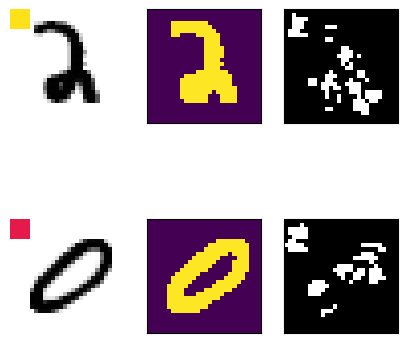

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(5, 5))

np.vectorize(ax_off)(ax)
fig_images = random.sample(range(10000), 2)
print (fig_images)
fig_images = [4113, 5008]

model_type = 'correlation'
data_type = 'correlation'

# normal_test_data
# corr_test_data
# color_anno_normal
# color_anno_corr

data = [corr_test_data[i] for i in fig_images]

for i, (image, ground_truth, label) in enumerate(data):
    data_ind = fig_images[i]
    masked_image = image * ground_truth
    ax[i, 0].imshow(image.permute(1,2,0))
    ax[i,0].set(frame_on=False)
    ax[i, 1].imshow(ground_truth)
    
    data_path = os.path.abspath(data_dir + '/' + model_type + '/digit/')
    with open(os.path.join(data_path, data_type + "_saliency_masks.pickle"), 'rb') as handle:
        saliency_masks = pickle.load(handle)
        saliency_image = np.expand_dims(saliency_masks[data_ind], axis=2)
        ax[i, 2].imshow(saliency_image, cmap='gray')
    
    print ('---Digit----')
    with open(os.path.join(data_path, data_type + "_shared_interest_scores.pickle"), 'rb') as handle:
        shared_interest_scores = pickle.load(handle)
        print ('IoU: ' + str(shared_interest_scores['iou_coverage'][data_ind]))
    with open(os.path.join(data_path, data_type + "_pointing_game.pickle"), 'rb') as handle:
        pointing_game = pickle.load(handle)
        print ('Pointing Game: ' + str(pointing_game[data_ind]))
    
    print ('---Color Block----')
    color_data_path = os.path.abspath(data_dir + '/' + model_type + '/color/')
    with open(os.path.join(color_data_path, data_type + "_shared_interest_scores.pickle"), 'rb') as handle:
        shared_interest_scores = pickle.load(handle)
        print ('IoU: ' + str(shared_interest_scores['iou_coverage'][data_ind]))
    with open(os.path.join(color_data_path, data_type + "_pointing_game.pickle"), 'rb') as handle:
        pointing_game = pickle.load(handle)
        print ('Pointing Game: ' + str(pointing_game[data_ind]))